# Tutorial 1: Neural Posterior Estimation (NPE)
Credit: Tri Nguyen and Claude Code

In this tutorial, we'll implement a neural posterior estimation (NPE) algorithm from scratch using PyTorch. NPE is a simulation-based inference method that uses neural networks to approximate the posterior distribution of parameters given observed data.

For simplicity, we'll use a one- or two-dimensional parameter space with a simple likelihood function. In each of the following experiments, our setup will be as follows:
- Parameter: $\theta$ sampled from a prior distribution $p(\theta)$
- Simulator: $p(x|\theta)$ which implicitly defines the likelihood function
- Observation: $x \sim p(x|\theta)$
- True posterior: $p(\theta|x)$

**Goal**: Learn the true posterior $p(\theta|x)$ using NPE, which approximates it with a neural network $q_\phi(\theta|x)$, where $\phi$ are the parameters of the neural network.

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from scipy.stats import multivariate_normal

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


---
# Part 1a: Gaussian Posterior on Gaussian Data

We'll start with a simple case where the true posterior distribution is Gaussian.
We'll implement a simple NPE model where the distribution is approximated using a Gaussian distribution parameterized by a neural network.

## 1. Generate the training data

Define a simulator that generates data from a 2D Gaussian likelihood with fixed mean and covariance.

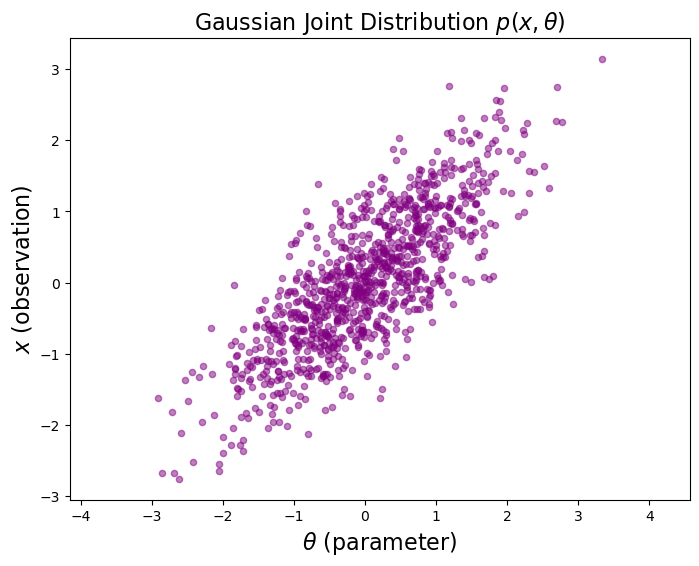

Sampled 1000 points from 2D Gaussian
Correlation between θ and x: 0.795


In [88]:
def sample_gaussian_joint(n_samples, mean=[0, 0], cov=[[1.0, 0.8], [0.8, 1.0]]):
    """
    Sample from a 2D Gaussian joint distribution p(x, θ).

    Parameters:
    - n_samples: number of samples
    - mean: [mean_theta, mean_x]
    - cov: 2x2 covariance matrix

    Returns:
    - theta: parameter values (1D)
    - x: observation values (1D)
    """
    samples = np.random.multivariate_normal(mean, cov, size=n_samples)
    theta = samples[:, 0]
    x = samples[:, 1]
    return theta, x

# Visualize the Gaussian joint distribution
theta_gauss_vis, x_gauss_vis = sample_gaussian_joint(1000)

plt.figure(figsize=(8, 6))
plt.scatter(theta_gauss_vis, x_gauss_vis, alpha=0.5, s=20, color='purple')
plt.xlabel(r'$\theta$ (parameter)', fontsize=16)
plt.ylabel(r'$x$ (observation)', fontsize=16)
plt.title(r'Gaussian Joint Distribution $p(x, \theta)$', fontsize=16)
plt.axis('equal')
plt.show()

print(f"Sampled {len(theta_gauss_vis)} points from 2D Gaussian")
print(f"Correlation between θ and x: {np.corrcoef(theta_gauss_vis, x_gauss_vis)[0,1]:.3f}")

In [89]:
# Generate training data from Gaussian
# feel free to experiment with different sample sizes, means, and covariances
n_training = 10_000
mean = [0, 0]
cov = [[1.0, 0.8], [0.8, 1.0]]
print(f"Generating {n_training} training samples from Gaussian...")

theta_train_gauss, x_train_gauss = sample_gaussian_joint(n_training, mean=mean, cov=cov)

print(f"✓ Training data generated")
print(f"  θ shape: {theta_train_gauss.shape}")
print(f"  x shape: {x_train_gauss.shape}")

Generating 10000 training samples from Gaussian...
✓ Training data generated
  θ shape: (10000,)
  x shape: (10000,)


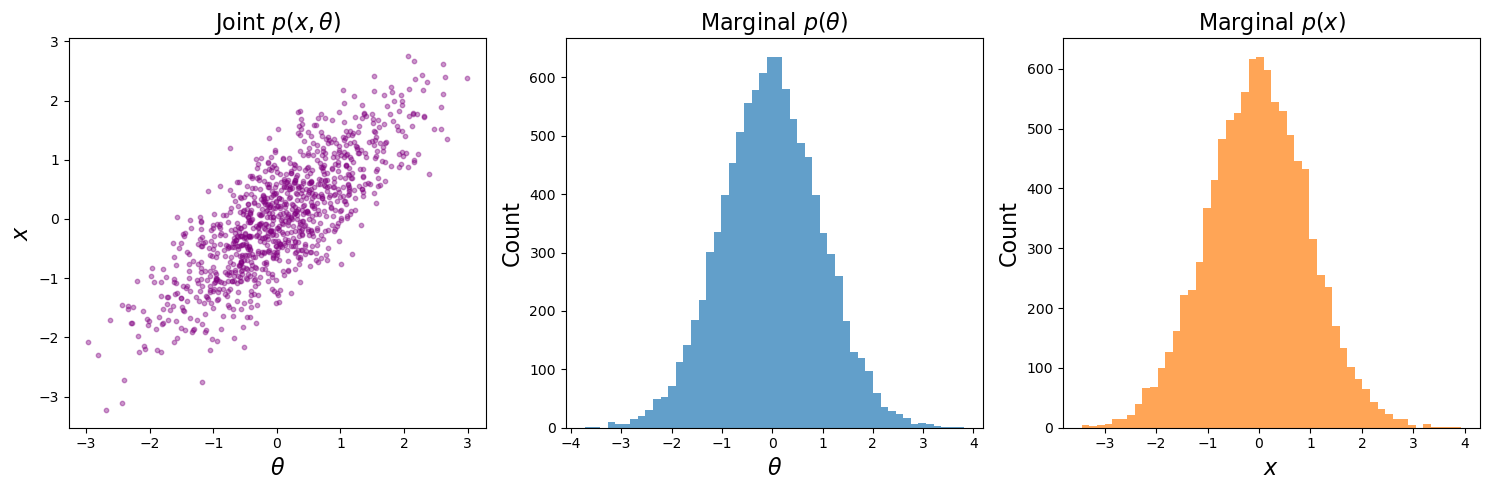

In [90]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].scatter(theta_train_gauss[:1000], x_train_gauss[:1000], alpha=0.4, s=10, color='purple')
axes[0].set_xlabel(r'$\theta$', fontsize=16)
axes[0].set_ylabel(r'$x$', fontsize=16)
axes[0].set_title(r'Joint $p(x, \theta)$', fontsize=16)

axes[1].hist(theta_train_gauss, bins=50, alpha=0.7, color='C0')
axes[1].set_xlabel(r'$\theta$', fontsize=16)
axes[1].set_ylabel('Count', fontsize=16)
axes[1].set_title(r'Marginal $p(\theta)$', fontsize=16)

axes[2].hist(x_train_gauss, bins=50, alpha=0.7, color='C1')
axes[2].set_xlabel(r'$x$', fontsize=16)
axes[2].set_ylabel('Count', fontsize=16)
axes[2].set_title(r'Marginal $p(x)$', fontsize=16)

plt.tight_layout()
plt.show()

## 2. Build an NPE with Gaussian Posterior

We'll explicitly model the posterior as a Gaussian distribution:

$$q_\phi(\theta|x) = \mathcal{N}(\theta; \mu_\phi(x), \sigma^2_\phi(x))$$

The neural network learns the mean $\mu_\phi(x)$ and standard deviation $\sigma_\phi(x)$. Note that in practice, instead of learning $\sigma_\phi(x)$ directly, we often learn $\log \sigma_\phi(x)$ to ensure numerical stability and positivity.

To learn the model parameters $\phi$, we minimize the negative log-likelihood of the observed data under the approximate posterior:

$$\mathcal{L}(\phi) = -\mathbb{E}_{p(x, \theta)}[\log q_\phi(\theta|x)] = -\mathbb{E}_{p(x, \theta)}\left[-\frac{1}{2}\log(2\pi\sigma^2_\phi(x)) - \frac{(\theta - \mu_\phi(x))^2}{2\sigma^2_\phi(x)}\right]$$

Under finite samples, this becomes:

$$\mathcal{L}(\phi) = -\frac{1}{N}\sum_{i=1}^N \log q_\phi(\theta_i|x_i)$$

where $(x_i, \theta_i) \sim p(x, \theta)$ are the observed data points.

In [91]:
class GaussianPosterior(nn.Module):
    """
    Neural network that models p(θ|x) as a Gaussian.

    Input: x (observation)
    Output: mean μ(x) and std σ(x) for p(θ|x)
    """

    def __init__(self, hidden_size=64):
        super().__init__()

        self.network = nn.Sequential(
            nn.Linear(1, hidden_size),  # input dimension is 1
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
        )

        # Output layers for mean and log std of Gaussian
        self.mean_layer = nn.Linear(hidden_size, 1)
        self.logstd_layer = nn.Linear(hidden_size, 1)

    def forward(self, x):
        """Predict Gaussian parameters μ(x), σ(x)"""
        features = self.network(x)
        mean = self.mean_layer(features)
        logstd = self.logstd_layer(features)
        return mean, logstd

    def log_prob(self, theta, x):
        """Compute log p(θ|x)"""
        mean, logstd = self.forward(x)
        var = torch.exp(2 * logstd)
        log_prob = -0.5 * (np.log(2 * np.pi) + 2 * logstd + ((theta - mean) ** 2) / var)
        return log_prob

    def sample(self, x, n_samples=1000):
        """Sample θ ~ p(θ|x)"""
        mean, logstd = self.forward(x)
        samples = mean + torch.exp(logstd) * torch.randn(x.shape[0], n_samples, 1)
        return samples

gaussian_model_v1 = GaussianPosterior(hidden_size=64)

## 3. Training

In [92]:
def train_model(model, theta_train, x_train, epochs=50, batch_size=256, lr=1e-3):
    """
    Train the posterior model.
    """
    theta_tensor = torch.tensor(theta_train, dtype=torch.float32).reshape(-1, 1)
    x_tensor = torch.tensor(x_train, dtype=torch.float32).reshape(-1, 1)

    dataset = TensorDataset(x_tensor, theta_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    losses = []
    print(f"Training for {epochs} epochs...\n")

    for epoch in range(epochs):
        epoch_loss = 0.0
        n_batches = 0

        for x_batch, theta_batch in dataloader:
            optimizer.zero_grad()
            log_prob = model.log_prob(theta_batch, x_batch)
            loss = -log_prob.mean()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            n_batches += 1

        avg_loss = epoch_loss / n_batches
        losses.append(avg_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1:3d}/{epochs} | Loss: {avg_loss:.4f}")

    print("\n✓ Training complete!")
    return losses

# Train on Gaussian data
# this is a simple model, so we only need a small number of epochs
# feel free to adjust epochs, batch size, and learning rate
gauss_losses_v1 = train_model(gaussian_model_v1, theta_train_gauss, x_train_gauss, epochs=50)

Training for 50 epochs...

Epoch  10/50 | Loss: 0.9048
Epoch  20/50 | Loss: 0.9033
Epoch  30/50 | Loss: 0.9109
Epoch  40/50 | Loss: 0.9115
Epoch  50/50 | Loss: 0.9073

✓ Training complete!


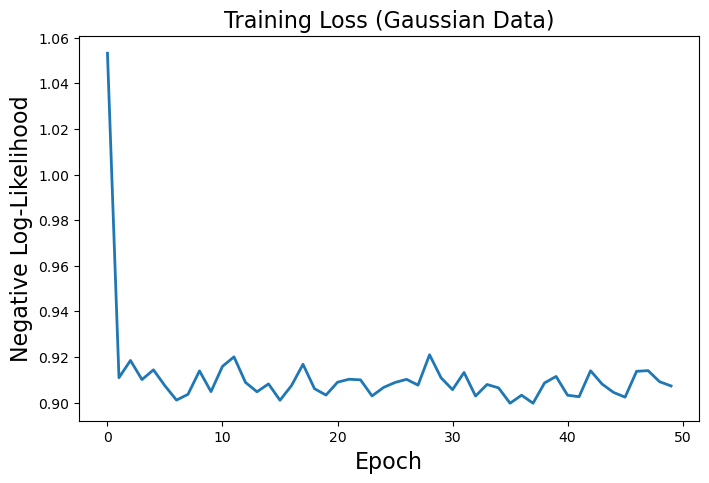

In [93]:
plt.figure(figsize=(8, 5))
plt.plot(gauss_losses_v1, linewidth=2)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Negative Log-Likelihood', fontsize=16)
plt.title('Training Loss (Gaussian Data)', fontsize=16)
plt.show()

## 5. Evaluate: Gaussian Posterior on Gaussian Data

Let's see if the learned $p(\theta|x)$ matches the true posterior.

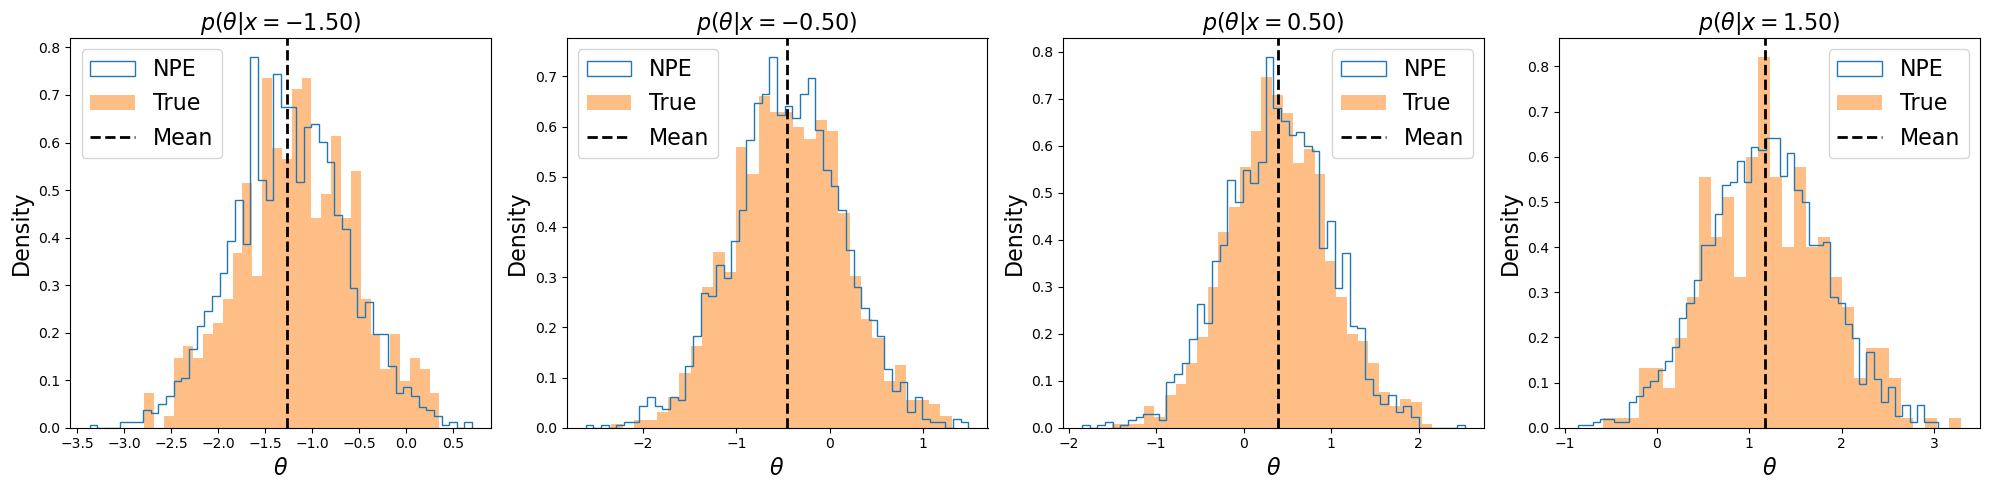

In [95]:
def plot_posterior_comparison(model, x_values, theta_train, x_train, title_prefix=""):
    """
    Compare learned p(θ|x) vs true p(θ|x) for different x values.
    """
    fig, axes = plt.subplots(1, len(x_values), figsize=(5*len(x_values), 5))
    if len(x_values) == 1:
        axes = [axes]

    for idx, x_val in enumerate(x_values):
        x_tensor = torch.tensor([[x_val]], dtype=torch.float32)

        # sample from the trained NPE model
        with torch.no_grad():
            mean, std = model(x_tensor)
            samples = model.sample(x_tensor, n_samples=2000).squeeze().numpy()

        # Plot the NPE samples
        axes[idx].hist(
            samples, bins=50, density=True, label='NPE', color='C0',
            histtype='step', lw=2)

        # Plot true posterior p(θ|x)
        # since we do not have the true posterior in closed form, we will simply
        # use the training data to estimate it locally around x_val
        x_margin = 0.15
        mask = np.abs(x_train - x_val) < x_margin
        axes[idx].hist(theta_train[mask], bins=30, alpha=0.5, density=True,
                    color='C1', label='True')

        axes[idx].axvline(mean.item(), color='k', linestyle='--',
                         lw=2, label=f'Mean')
        axes[idx].set_xlabel(r'$\theta$', fontsize=16)
        axes[idx].set_ylabel('Density', fontsize=16)
        axes[idx].set_title(f'{title_prefix}$p(\\theta | x={x_val:.2f})$', fontsize=16)
        axes[idx].legend(fontsize=16)

    plt.tight_layout()
    plt.show()

plot_posterior_comparison(
    gaussian_model_v1, [-1.5, -0.5, 0.5, 1.5], theta_train_gauss, x_train_gauss)


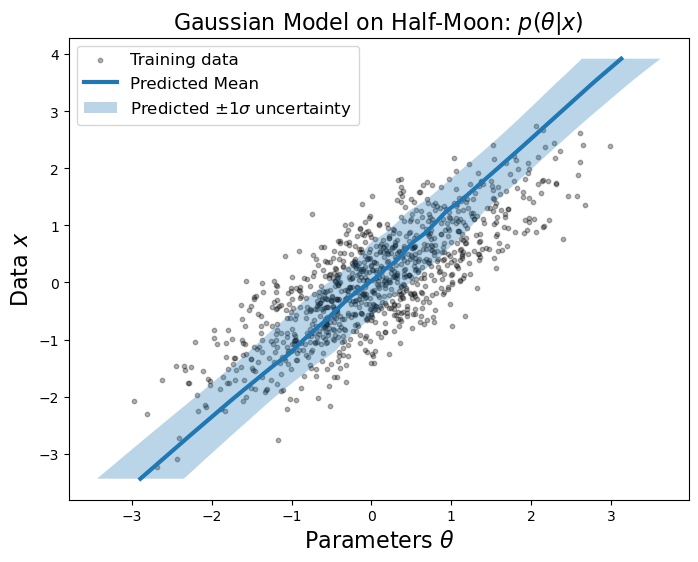

In [138]:
# Visualize full posterior
x_grid = np.linspace(x_train_gauss.min(), x_train_gauss.max(), 100)
x_grid_tensor = torch.tensor(x_grid, dtype=torch.float32).reshape(-1, 1)

with torch.no_grad():
    means, stds = gaussian_model_v1(x_grid_tensor)
    means = means.squeeze().numpy()
    stds = stds.squeeze().numpy()

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(theta_train_gauss[:1000], x_train_gauss[:1000], alpha=0.3, s=10,
           label='Training data', color='k')
ax.plot(means, x_grid, 'C0-', linewidth=3, label=r'Predicted Mean')
ax.fill_betweenx(x_grid, means - stds, means + stds,
                 alpha=0.3, label=r'Predicted $\pm 1\sigma$ uncertainty')
ax.set_xlabel(r'Parameters $\theta$', fontsize=16)
ax.set_ylabel(r'Data $x$', fontsize=16)
ax.set_title(r'Gaussian Model on Half-Moon: $p(\theta|x)$', fontsize=16)
ax.legend(fontsize=12)
plt.show()

---
# Part 1b: Gaussian Posterior on Half-Moon Data

Now let's see what happens when we apply the **same Gaussian posterior** to a **non-Gaussian** distribution! We'll use a half-moon shaped $p(x, \theta)$.

## 6. Generate the training data

The half-moon distribution has complex, non-linear structure.

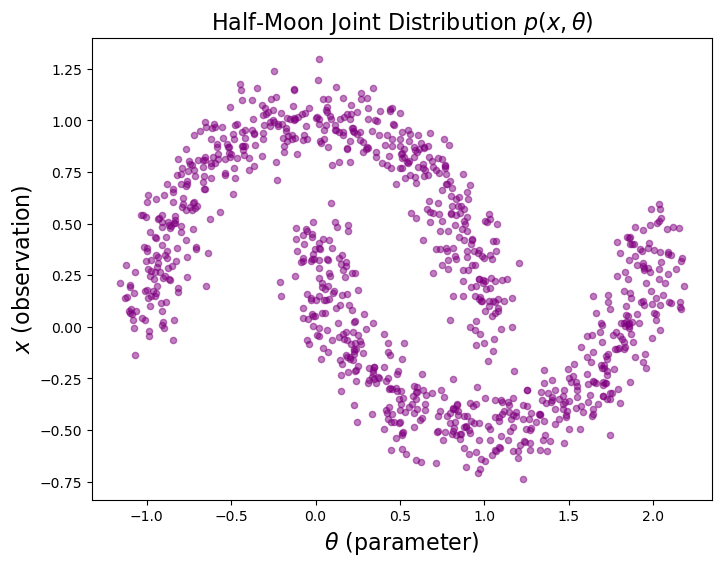

Sampled 1000 points from half-moon
θ range: [-1.16, 2.18]
x range: [-0.74, 1.30]


In [96]:
def sample_halfmoon_joint(n_samples, noise=0.1):
    """
    Sample from half-moon joint distribution p(x, θ).

    Returns:
    - theta: parameter values (1D)
    - x: observation values (1D)
    """
    samples, labels = make_moons(n_samples=n_samples, noise=noise, random_state=None)

    theta = samples[:, 0]  # First dimension
    x = samples[:, 1]      # Second dimension

    return theta, x

# Visualize
theta_moon_vis, x_moon_vis = sample_halfmoon_joint(1000)

plt.figure(figsize=(8, 6))
plt.scatter(theta_moon_vis, x_moon_vis, alpha=0.5, s=20, color='purple')
plt.xlabel(r'$\theta$ (parameter)', fontsize=16)
plt.ylabel(r'$x$ (observation)', fontsize=16)
plt.title(r'Half-Moon Joint Distribution $p(x, \theta)$', fontsize=16)
plt.show()

print(f"Sampled {len(theta_moon_vis)} points from half-moon")
print(f"θ range: [{theta_moon_vis.min():.2f}, {theta_moon_vis.max():.2f}]")
print(f"x range: [{x_moon_vis.min():.2f}, {x_moon_vis.max():.2f}]")

In [97]:
n_training = 10000
print(f"Generating {n_training} training samples from half-moon...")

theta_train_moon, x_train_moon = sample_halfmoon_joint(n_training, noise=0.1)

print(f"✓ Training data generated")
print(f"  θ shape: {theta_train_gauss.shape}")
print(f"  x shape: {x_train_gauss.shape}")

Generating 10000 training samples from half-moon...
✓ Training data generated
  θ shape: (10000,)
  x shape: (10000,)


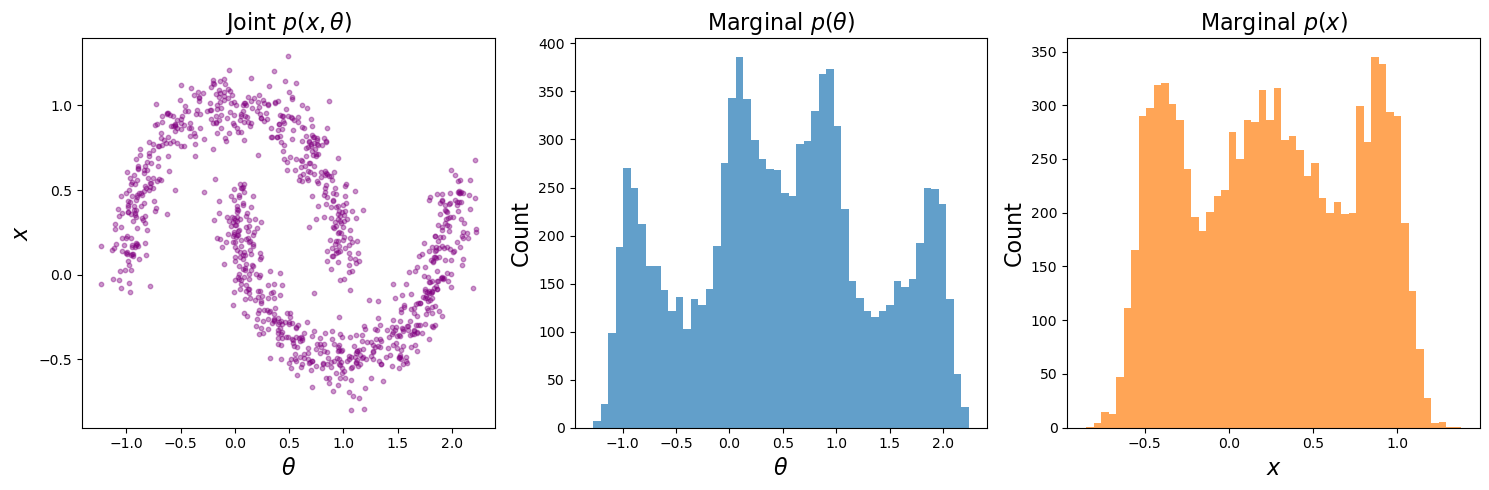

In [103]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].scatter(theta_train_moon[:1000], x_train_moon[:1000], alpha=0.4, s=10, color='purple')
axes[0].set_xlabel(r'$\theta$', fontsize=16)
axes[0].set_ylabel(r'$x$', fontsize=16)
axes[0].set_title(r'Joint $p(x, \theta)$', fontsize=16)

axes[1].hist(theta_train_moon, bins=50, alpha=0.7, color='C0')
axes[1].set_xlabel(r'$\theta$', fontsize=16)
axes[1].set_ylabel('Count', fontsize=16)
axes[1].set_title(r'Marginal $p(\theta)$', fontsize=16)

axes[2].hist(x_train_moon, bins=50, alpha=0.7, color='C1')
axes[2].set_xlabel(r'$x$', fontsize=16)
axes[2].set_ylabel('Count', fontsize=16)
axes[2].set_title(r'Marginal $p(x)$', fontsize=16)

plt.tight_layout()
plt.show()

## 7. Train Gaussian Posterior on Half-Moon Data

Let's see what happens when we use a Gaussian posterior on non-Gaussian data...

In [104]:
gaussian_model_v2 = GaussianPosterior(hidden_size=64)
print("Training Gaussian model on half-moon data...")

gauss_losses_v2 = train_model(gaussian_model_v2, theta_train_moon, x_train_moon, epochs=50)

Training Gaussian model on half-moon data...
Training for 50 epochs...

Epoch  10/50 | Loss: 0.9742
Epoch  20/50 | Loss: 0.9749
Epoch  30/50 | Loss: 0.9707
Epoch  40/50 | Loss: 0.9780
Epoch  50/50 | Loss: 0.9739

✓ Training complete!


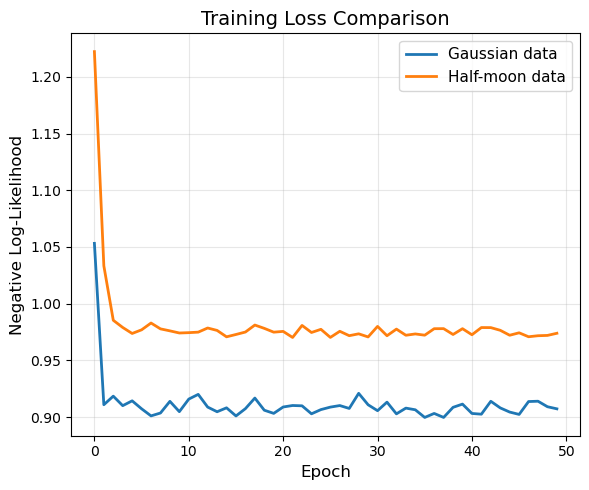

Final loss (Gaussian data): 0.9073
Final loss (Half-moon data): 0.9739

Higher loss on half-moon suggests model mismatch!


In [108]:
# Compare losses
fig, ax = plt.subplots(1, figsize=(6, 5))

ax.plot(gauss_losses_v1, linewidth=2, label='Gaussian data')
ax.plot(gauss_losses_v2, linewidth=2, label='Half-moon data')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Negative Log-Likelihood', fontsize=12)
ax.set_title('Training Loss Comparison', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final loss (Gaussian data): {gauss_losses_v1[-1]:.4f}")
print(f"Final loss (Half-moon data): {gauss_losses_v2[-1]:.4f}")
print(f"\nHigher loss on half-moon suggests model mismatch!")

## 8. Evaluate: Gaussian Posterior Fails on Half-Moon

We will see that the Gaussian posterior fails to capture the true posterior shape.

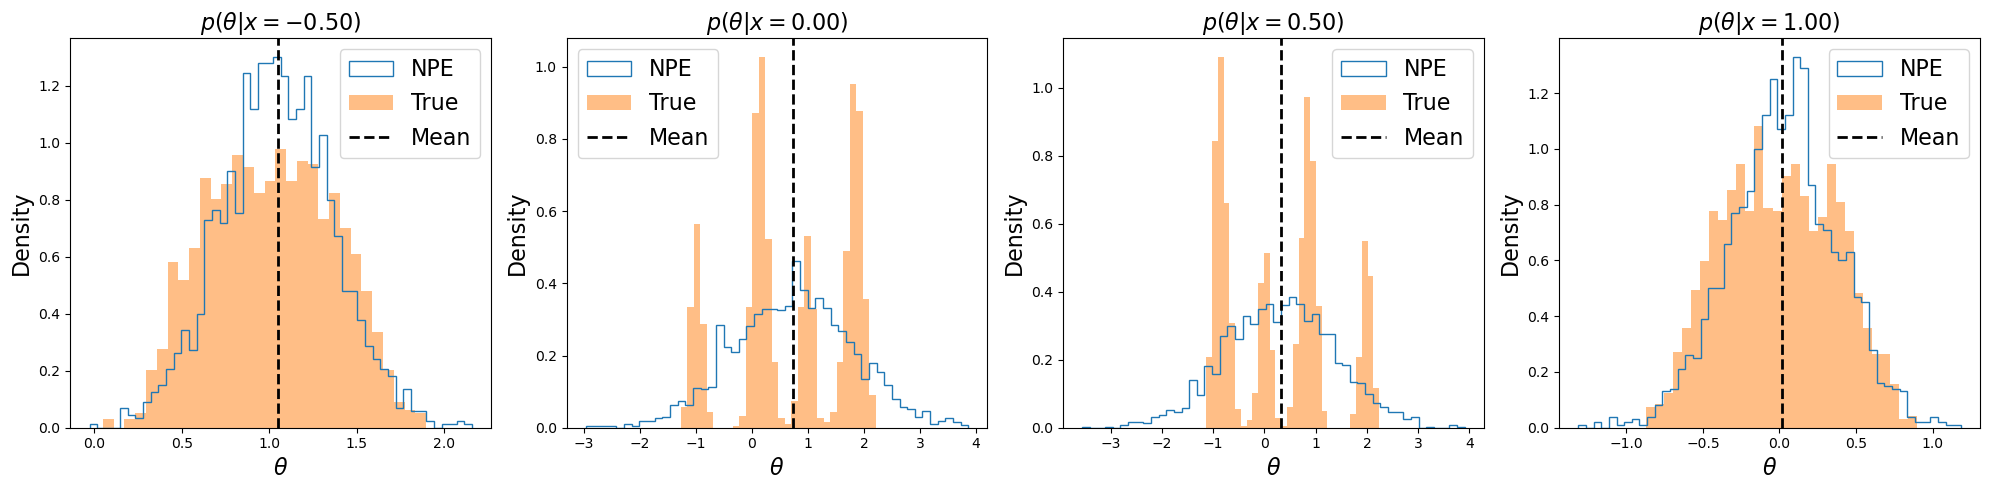

In [144]:
test_x_moon = [-0.5, 0.0, 0.5, 1.0]
plot_posterior_comparison(
    gaussian_model_v2, test_x_moon, theta_train_moon, x_train_moon)

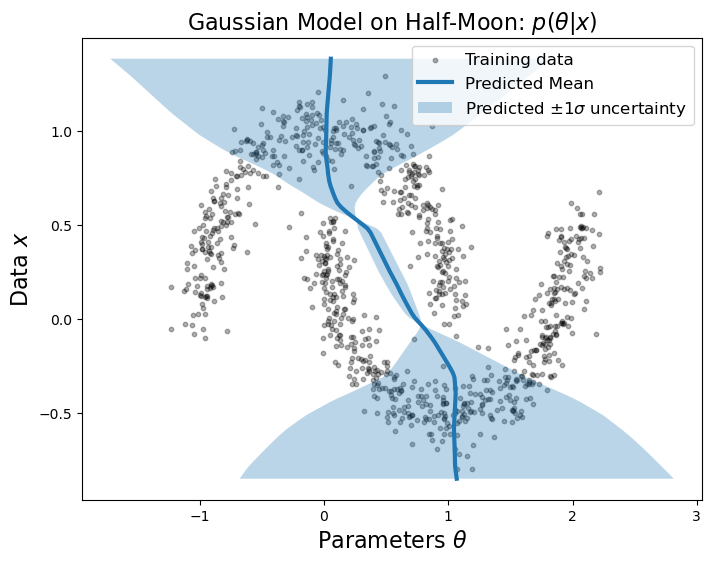

In [145]:
# Visualize full posterior
x_grid = np.linspace(x_train_moon.min(), x_train_moon.max(), 100)
x_grid_tensor = torch.tensor(x_grid, dtype=torch.float32).reshape(-1, 1)

with torch.no_grad():
    means, stds = gaussian_model_v2(x_grid_tensor)
    means = means.squeeze().numpy()
    stds = stds.squeeze().numpy()

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(theta_train_moon[:1000], x_train_moon[:1000], alpha=0.3, s=10,
           label='Training data', color='k')
ax.plot(means, x_grid, 'C0-', linewidth=3, label=r'Predicted Mean')
ax.fill_betweenx(x_grid, means - stds, means + stds,
                 alpha=0.3, label=r'Predicted $\pm 1\sigma$ uncertainty')
ax.set_xlabel(r'Parameters $\theta$', fontsize=16)
ax.set_ylabel(r'Data $x$', fontsize=16)
ax.set_title(r'Gaussian Model on Half-Moon: $p(\theta|x)$', fontsize=16)
ax.legend(fontsize=12)
plt.show()

---
# Part 2: Flow-based Posterior with Zuko

Since the Gaussian posterior failed on the half-moon data, we need a more flexible posterior approximation. It is common to use normalizing flows for this purpose. 

Normalizing flows are a powerful class of generative models that transform a simple base distribution (like a Gaussian) into a complex target distribution through a series of invertible transformations. We'll use the `zuko` library with Neural Spline Flows (NSF).

For more details on normalizing flows and the Zuko library, check out the [Zuko documentation](https://zuko.readthedocs.io/stable/tutorials.html).

In [146]:
# Install zuko if needed
try:
    import zuko
    print("✓ zuko already installed")
except ImportError:
    print("Installing zuko...")
    !pip install zuko
    import zuko
    print("✓ zuko installed")

from zuko.flows import NSF  # Neural Spline Flow

✓ zuko already installed


## 9. Build the Flow-based NPE

Normalizing flows provide a flexible way to model complex distributions by learning a transformation from a simple base distribution. Instead of directly modeling $p(\theta|x)$ as a Gaussian, we learn a bijective (invertible) transformation:
$$\theta = T(z; x) \quad \text{where} \quad z \sim \mathcal{N}(0, 1)$$

Here:
- $z$ is sampled from a simple Gaussian base distribution
- $T(\cdot; x)$ is a neural network that transforms $z$ into $\theta$ conditioned on observation $x$
- The transformation is **invertible** and **differentiable**, allowing us to compute densities via the change of variables formula:

$$p(\theta|x) = p(z) \left| \det \frac{\partial T^{-1}(\theta; x)}{\partial \theta} \right|$$

Why flows work better than Gaussians:
- Gaussians can only model unimodal, symmetric distributions
- Flows can model arbitrary distributions by composing multiple transformations
- Each transformation $T$ warps the space, allowing complex shapes like the half-moon

We'll use **Neural Spline Flows (NSF)**, which use monotonic rational-quadratic splines as the transformation. This is a powerful and flexible choice for 1D posteriors!

In [150]:
class FlowPosterior(nn.Module):
    """
    Flow-based model for p(θ|x) using Neural Spline Flows.
    """

    def __init__(self, hidden_size=64, embedding_size=8, transforms=5):
        super().__init__()

        # It is common to embed the context x before passing to the flow
        # in this case, it is not strictly necessary since x is 1D, but we include it for completeness
        self.embedding_network = nn.Sequential(
            nn.Linear(1, hidden_size),  # input dimension is 1
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, embedding_size),
        )

        # NSF: Neural Spline Flow
        self.flow = NSF(
            features=1,                 # dimension of θ
            context=embedding_size,     # dimension of embedded x
            transforms=transforms,      # number of transformations
            hidden_features=[hidden_size, hidden_size],  # hidden layers in each transform
        )

    def forward(self, x):
        """Return the flow conditioned on x"""
        x_embedded = self.embedding_network(x)
        return self.flow(x_embedded)

    def log_prob(self, theta, x):
        """Compute log p(θ|x)"""
        x_embedded = self.embedding_network(x)
        return self.flow(x_embedded).log_prob(theta)

    def sample(self, x, n_samples=1000):
        """Sample θ ~ p(θ|x)"""
        x_embedded = self.embedding_network(x)
        flow_i = self.flow(x_embedded)
        return flow_i.sample((n_samples,))

flow_model = FlowPosterior(
    hidden_size=64,
    embedding_size=8,
    transforms=5
)

## 10. Train Flow on Half-Moon Data

The training objective is the same. We minimize the negative log-likelihood of the observed data under the flow-based posterior:

$$\mathcal{L}(\phi) = -\mathbb{E}_{p(x, \theta)}[\log q_\phi(\theta|x)]$$

where $q_\phi(\theta|x)$ is now defined via the normalizing flow.

In [151]:
print("Training flow model on half-moon data...")
flow_losses = train_model(flow_model, theta_train_moon, x_train_moon, epochs=50)

Training flow model on half-moon data...
Training for 50 epochs...

Epoch  10/50 | Loss: 0.5169
Epoch  20/50 | Loss: 0.4688
Epoch  30/50 | Loss: 0.4603
Epoch  40/50 | Loss: 0.4527
Epoch  50/50 | Loss: 0.4699

✓ Training complete!


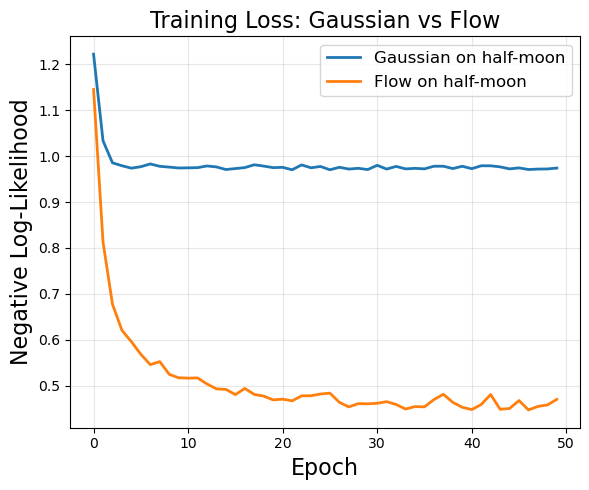

Final loss - Gaussian: 0.9739
Final loss - Flow: 0.4699
Improvement: 0.5040


In [156]:
# Compare all losses
fig, ax = plt.subplots(1, figsize=(6, 5))

ax.plot(gauss_losses_v2, linewidth=2, label='Gaussian on half-moon')
ax.plot(flow_losses, linewidth=2, label='Flow on half-moon')
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('Negative Log-Likelihood', fontsize=16)
ax.set_title('Training Loss: Gaussian vs Flow', fontsize=16)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final loss - Gaussian: {gauss_losses_v2[-1]:.4f}")
print(f"Final loss - Flow: {flow_losses[-1]:.4f}")
print(f"Improvement: {gauss_losses_v2[-1] - flow_losses[-1]:.4f}")

## 11. Evaluate Flow Model

The flow should capture the complex posterior much better!

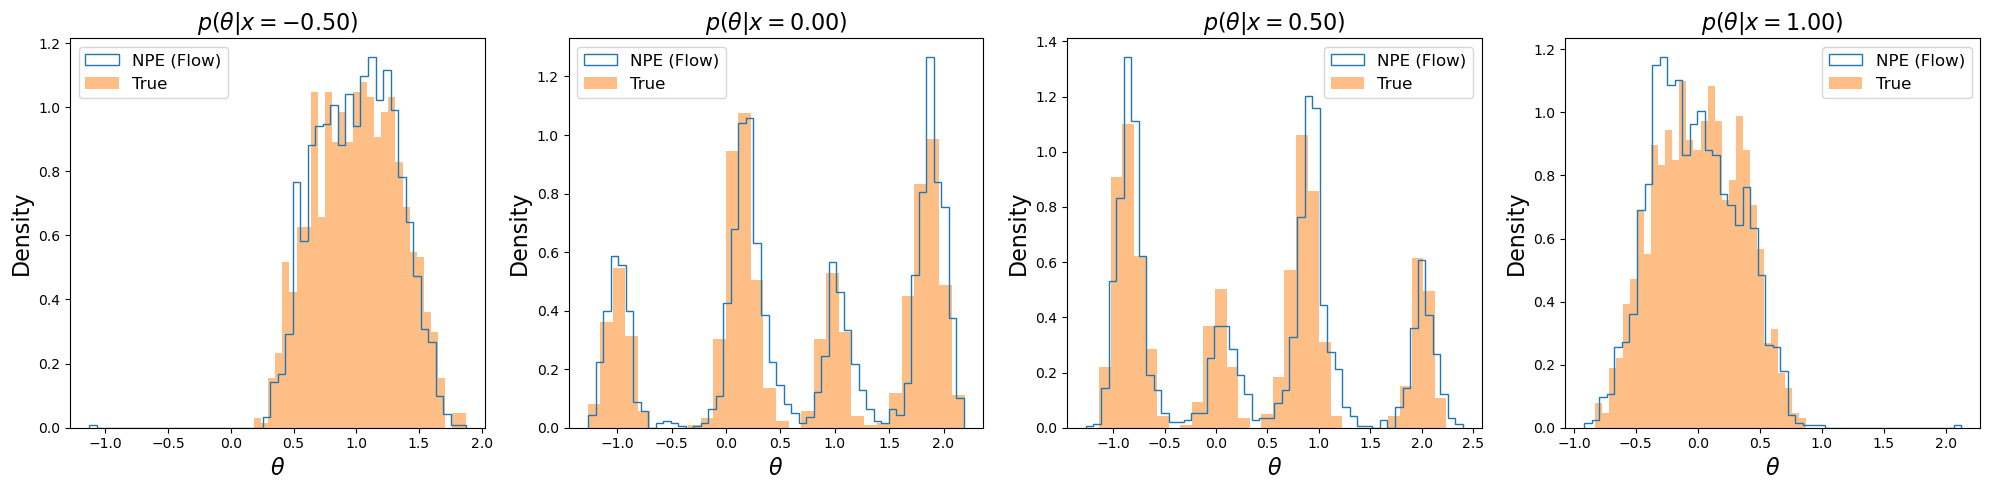

In [169]:
def plot_posterior_flow(model, x_values, theta_train, x_train):
    """
    Visualize p(θ|x) from flow model.
    """
    fig, axes = plt.subplots(1, len(x_values), figsize=(5*len(x_values), 5))
    if len(x_values) == 1:
        axes = [axes]

    for idx, x_val in enumerate(x_values):
        x_tensor = torch.FloatTensor([[x_val]])
        with torch.no_grad():
            samples = model.sample(x_tensor, n_samples=2000).squeeze().numpy()

        axes[idx].hist(
            samples, bins=50, density=True, label='NPE (Flow)', color='C0',
            histtype='step', lw=2)

        # True conditional
        x_margin = 0.1
        mask = np.abs(x_train - x_val) < x_margin
        axes[idx].hist(
            theta_train[mask], bins=30, alpha=0.5, density=True, color='C1', label='True')

        axes[idx].set_xlabel(r'$\theta$', fontsize=16)
        axes[idx].set_ylabel('Density', fontsize=16)
        axes[idx].set_title(f'$p(\\theta | x={x_val:.2f})$', fontsize=16)
        axes[idx].legend(fontsize=12)

    plt.tight_layout()
    plt.show()

plot_posterior_flow(flow_model, test_x_moon, theta_train_moon, x_train_moon)

Computing posterior density on grid...


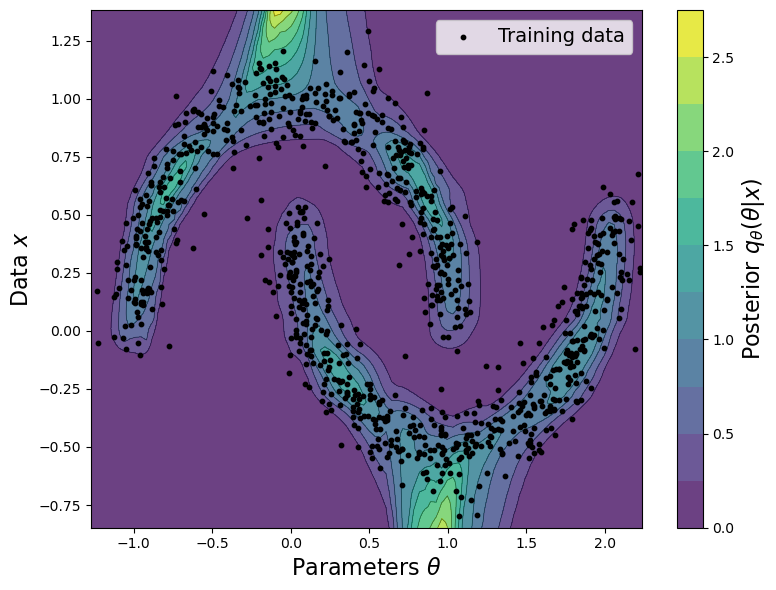

In [231]:
# Visualize full posterior from flow model as a contour plot
print("Computing posterior density on grid...")

# Create a 2D grid
theta_grid = np.linspace(theta_train_moon.min(), theta_train_moon.max(), 100)
x_grid = np.linspace(x_train_moon.min(), x_train_moon.max(), 100)

theta_mesh, x_mesh = np.meshgrid(theta_grid, x_grid)

# Compute log p(theta|x) on the grid
log_probs = np.zeros_like(theta_mesh)
for i in range(len(x_grid)):
    x_val = x_grid[i]
    x_tensor = torch.tensor([[x_val]], dtype=torch.float32).repeat(len(theta_grid), 1)
    theta_tensor = torch.tensor(theta_grid, dtype=torch.float32).reshape(-1, 1)

    with torch.no_grad():
        log_probs[i, :] = flow_model.log_prob(theta_tensor, x_tensor).squeeze().numpy()

# Convert to probability density (exponentiate)
probs = np.exp(log_probs)

fig, ax = plt.subplots(1, figsize=(8, 6))

# Plot contour of the learned posterior
contour = ax.contourf(theta_mesh, x_mesh, probs, levels=10, cmap='viridis', alpha=0.8)
ax.contour(theta_mesh, x_mesh, probs, levels=10, colors='k', linewidths=0.5, alpha=0.5)

# Overlay training data
ax.scatter(theta_train_moon[:1000], x_train_moon[:1000], alpha=1, s=10,
           label='Training data', color='k')

ax.set_xlabel(r'Parameters $\theta$', fontsize=16)
ax.set_ylabel(r'Data $x$', fontsize=16)
ax.legend(fontsize=14)

# Add colorbar
cbar = plt.colorbar(contour, ax=ax)
cbar.set_label(r'Posterior $q_\theta(\theta|x)$', fontsize=16)

plt.tight_layout()
plt.show()

---
## Summary

In this tutorial, we explored two approaches to neural posterior estimation and demonstrated why normalizing flows have become the standard method.

### What We Demonstrated

**Part 1a: Gaussian Posterior on Gaussian Data**
- Modeled $p(\theta|x) = \mathcal{N}(\theta; \mu(x), \sigma^2(x))$ using a simple neural network
- Worked well because the true posterior was also Gaussian
- Fast training and easy implementation

**Part 1b: Gaussian Posterior on Half-Moon Data**
- Applied the same Gaussian model to non-Gaussian data
- **Failed** to capture the complex curved structure
- Higher training loss and poor posterior approximations
- Demonstrated the limitation: Gaussian posteriors cannot represent arbitrary distributions

**Part 2: Flow-based Posterior**
- Used normalizing flows (Neural Spline Flows) to model $p(\theta|x)$
- Successfully captured the half-moon structure
- Significantly lower training loss (0.47 vs 0.97)
- Accurate posterior approximations across all conditioning values

### Key Takeaway

**For NPE applications, use normalizing flows.** 

While Gaussian posteriors are simpler, they are only suitable when you *know* the posterior is approximately Gaussian (which is rarely the case in practice). Flows provide:
- **Flexibility**: Can represent arbitrary posterior distributions
- **Reliability**: Work well even when posterior structure is unknown
- **Standard practice**: The de facto choice in modern simulation-based inference

The additional complexity of flows over Gaussian models is minimal with modern libraries like `zuko`, but the benefits are substantial. Unless you have strong prior knowledge that your posterior is Gaussian, just use flows.